<a href="https://colab.research.google.com/github/jeffvun/Machine-Learning-Labs/blob/main/MobileNetV2_fine_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 4


In [3]:
# Define data directories and categories
data_dir = '/content/drive/MyDrive/DataSet/train/ALL'
categories = ['Benign', 'Early', 'Pre', 'Pro']

# Create an empty DataFrame to store file paths and corresponding labels
data = []

# Load data by iterating through categories and collecting file paths
for category_id, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith('.jpg'):
          data.append((os.path.join(category_dir, filename), category))

In [4]:
# Convert the data list into a DataFrame
data_df = pd.DataFrame(data, columns=['FilePath', 'Category'])

In [5]:
# Split the data into training, testing, and validation sets
train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Print the number of samples in each set
print(f"Number of samples in training set: {len(train_data)}")
print(f"Number of samples in testing set: {len(test_data)}")
print(f"Number of samples in validation set: {len(val_data)}")


Number of samples in training set: 2343
Number of samples in testing set: 652
Number of samples in validation set: 261


In [6]:
# Create data generators
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [7]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="FilePath",
    y_col="Category",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="FilePath",
    y_col="Category",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="FilePath",
    y_col="Category",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2343 validated image filenames belonging to 4 classes.
Found 261 validated image filenames belonging to 4 classes.
Found 652 validated image filenames belonging to 4 classes.


In [8]:
# Load and configure MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet",
)

#Adding custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 [==============================] - 2s 0us/step


In [9]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Train the model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, verbose=1)


Epoch 1/10
74/74 [==============================] - 1461s 20s/step - loss: 0.6333 - accuracy: 0.7845 - val_loss: 0.2226 - val_accuracy: 0.9042
Epoch 2/10
74/74 [==============================] - 37s 499ms/step - loss: 0.2646 - accuracy: 0.8963 - val_loss: 0.1251 - val_accuracy: 0.9502
Epoch 3/10
74/74 [==============================] - 40s 536ms/step - loss: 0.2196 - accuracy: 0.9176 - val_loss: 0.1241 - val_accuracy: 0.9540
Epoch 4/10
74/74 [==============================] - 38s 517ms/step - loss: 0.1701 - accuracy: 0.9407 - val_loss: 0.0914 - val_accuracy: 0.9732
Epoch 5/10
74/74 [==============================] - 38s 520ms/step - loss: 0.1619 - accuracy: 0.9420 - val_loss: 0.1748 - val_accuracy: 0.9464
Epoch 6/10
74/74 [==============================] - 37s 497ms/step - loss: 0.1595 - accuracy: 0.9420 - val_loss: 0.0872 - val_accuracy: 0.9732
Epoch 7/10
74/74 [==============================] - 38s 521ms/step - loss: 0.1378 - accuracy: 0.9492 - val_loss: 0.0795 - val_accuracy: 0.9655

In [18]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 [==============================] - 10s 468ms/step - loss: 0.1350 - accuracy: 0.9540
Test Accuracy: 95.40%


21/21 [==============================] - 10s 489ms/step


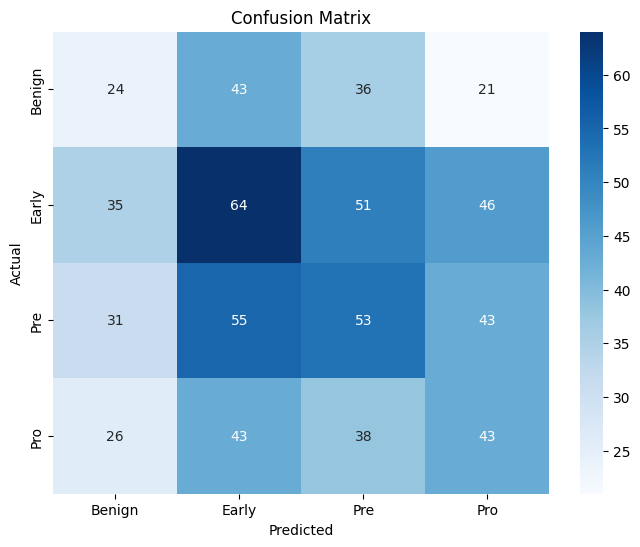

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['Benign', 'Early', 'Pre', 'Pro']

# Generate the confusion matrix
true_labels = test_generator.classes
predicted_labels = np.argmax(model.predict(test_generator), axis=1)
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# Print the classification report
classification_report_str = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(classification_report_str)


Classification Report:
              precision    recall  f1-score   support

      Benign       0.21      0.19      0.20       124
       Early       0.31      0.33      0.32       196
         Pre       0.30      0.29      0.29       182
         Pro       0.28      0.29      0.28       150

    accuracy                           0.28       652
   macro avg       0.27      0.27      0.27       652
weighted avg       0.28      0.28      0.28       652



In [24]:
# Export the model to a directory
model.save('leukemia_classifier_model')


In [32]:
# Save the Keras model architecture and weights
model.save("leukemia_keras_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
